## Setup

In [37]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave

from ipywidgets import interact, fixed
from IPython.display import clear_output

%matplotlib inline

## Create utility functions

In [13]:
#callback invoked by the interact ipython method for scrolling through the image stacks of
#the two images (moving and fixed)
def display_images(fixed_npa, moving_npa):
    #create a figure with two subplots and the specified size
    plt.subplots(1,2,figsize=(10,8))
    
    #draw the fixed image in the first subplot
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa,cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    #draw the moving image in the second subplot
    plt.subplot(1,2,2)
    plt.imshow(moving_npa,cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')

#callback invoked by the ipython interact method for scrolling and modifying the alpha blending
#of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    
    
#callback invoked when the StartEvent happens, sets up our new data
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

#callback invoked when the EndEvent happens, do cleanup of data and figure
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    #close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

#callback invoked when the IterationEvent happens, update our data and display new figure    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    #clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    #plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
#callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
#metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [28]:
from showit import image

def Show(img):
    simg = sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkUInt8)
    image(sitk.GetArrayFromImage(simg)/255.)
    
def cShow(img1, img2):
    simg1 = sitk.Cast(sitk.RescaleIntensity(img1), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(img2), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1/2.+simg2/2.)
    image(sitk.GetArrayFromImage(cimg)/255.)

## Load and preprocess data

In [105]:
from thunder.images import fromtif
from glob import glob

directory = '/Users/nick/Dropbox/work/projects/imaging-janelia/Trace/160922/'
path = directory + 'Cortex_Horizontal_Sections/EmxCre_Slide*.tif'

files = glob(path)

In [106]:
data = [fromtif(f, nplanes=1) for f in files]

In [107]:
from numpy import pad, asarray

def pad_data(data):
    maxY = max([d.shape[1] for d in data])
    maxX = max([d.shape[2] for d in data])
    return asarray([pad(d.toarray(),((0, 0), (0, maxY-d.shape[1]), (0, maxX-d.shape[2])), 'edge') for d in data])

In [108]:
data = pad_data(data)

### select gfp channel

In [109]:
raw = data[:,1,:,:]

In [111]:
imsave(directory + 'processed/raw.tif', raw, plugin='tifffile', photometric='minisblack')

## Register data

In [112]:
fixed_image = sitk.GetImageFromArray(raw[raw.shape[0]/2])
moving_image = sitk.GetImageFromArray(raw[0])
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32) 
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

Show fixed and moving image

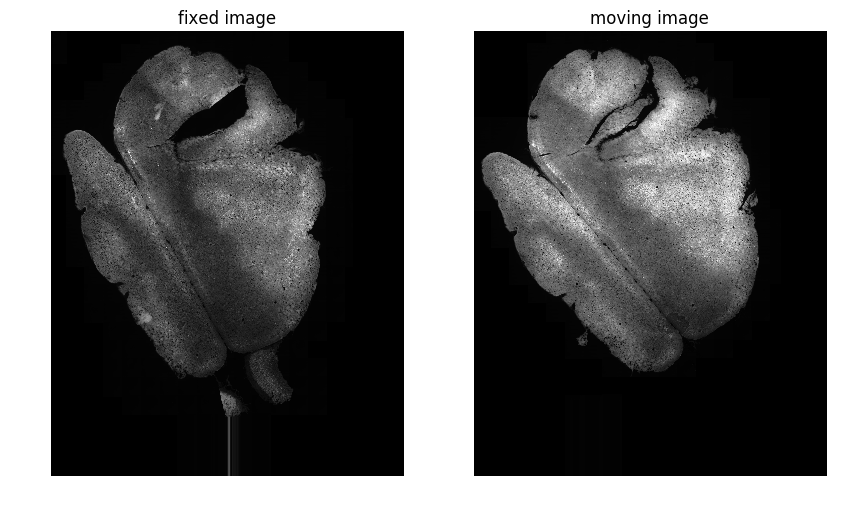

In [113]:
interact(display_images, fixed_npa = fixed(sitk.GetArrayFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayFromImage(moving_image)));

Do initial transformation

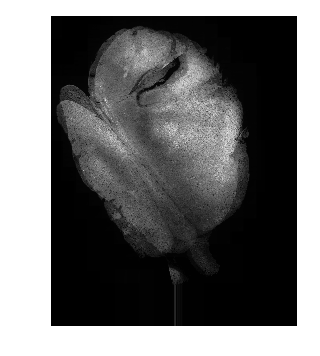

In [114]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

### initial alignment

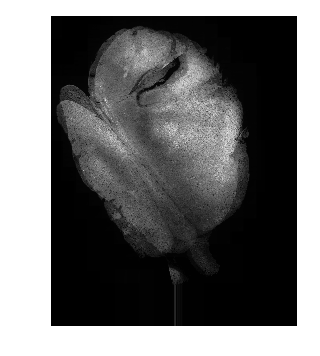

In [115]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

### registration

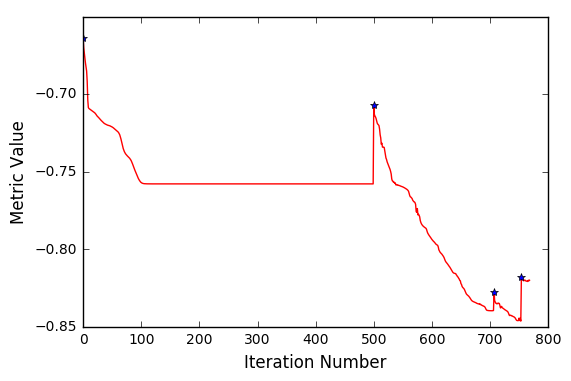

In [116]:
registration_method = sitk.ImageRegistrationMethod()

#similarity metric settings
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

#optimizer settings
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=250, convergenceMinimumValue=1e-9, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

#setup for the multi-resolution framework            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8, 4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

#don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [117]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.820346798431
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 15.


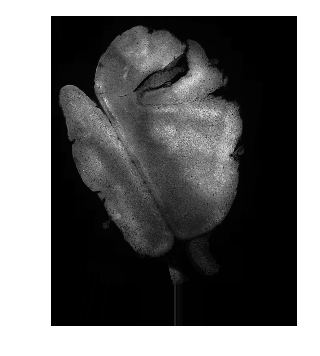

In [118]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

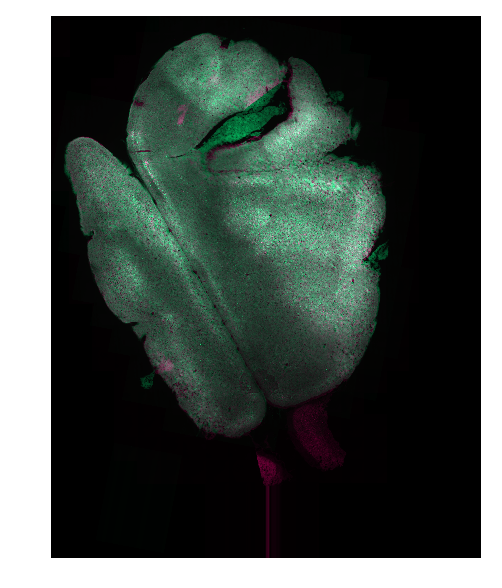

In [119]:
cShow(fixed_image, moving_resampled)

## Align stack

In [145]:
def align_stack(data, center=True):
    aligned = []
    for i in range(len(data)):
        if i == 0 and not center:
            aligned.append(data[i])
        else:
            if not center:
                fixed_image = sitk.GetImageFromArray(aligned[i-1])
            else:
                fixed_image = sitk.GetImageFromArray(data[data.shape[0]/2])
                
            moving_image = sitk.GetImageFromArray(data[i])
            
            initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
            
            registration_method = sitk.ImageRegistrationMethod()

            #similarity metric settings
            registration_method.SetMetricAsCorrelation()
            registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
            registration_method.SetMetricSamplingPercentage(0.01)

            registration_method.SetInterpolator(sitk.sitkLinear)

            #optimizer settings
            registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=250, convergenceMinimumValue=1e-9, convergenceWindowSize=10)
            registration_method.SetOptimizerScalesFromPhysicalShift()

            #setup for the multi-resolution framework            
            registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
            registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
            registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

            #don't optimize in-place, we would possibly like to run this cell multiple times
            registration_method.SetInitialTransform(initial_transform, inPlace=False)

            final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                          sitk.Cast(moving_image, sitk.sitkFloat32))

            moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())
            
            aligned.append(sitk.GetArrayFromImage(moving_resampled))
        
    return asarray(aligned)
            

In [127]:
aligned = align_stack(raw)

In [128]:
imsave(directory + 'processed/aligned.tif', aligned, plugin='tifffile', photometric='minisblack')

### rotate

In [129]:
mean = aligned.mean(axis=0)

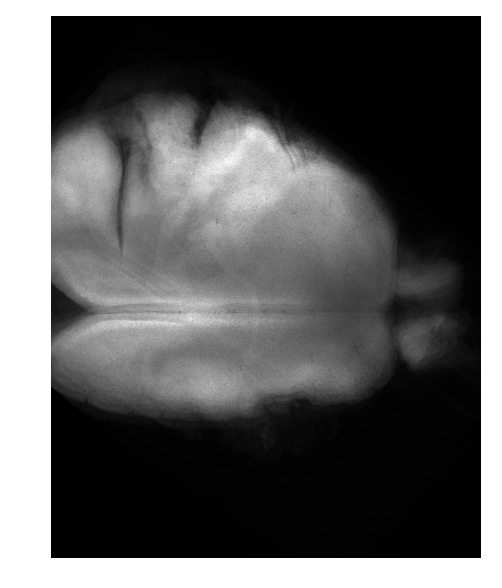

In [130]:
rotation_x = np.pi/180*50

moving_image = sitk.GetImageFromArray(mean)
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(moving_image)
resample.SetInterpolator(sitk.sitkLinear)
# Rotate around the physical center of the image. 
rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in moving_image.GetSize()])
transform = sitk.Euler2DTransform(rotation_center, rotation_x, (0,0))
resample.SetTransform(transform)
modified_moving_image = resample.Execute(moving_image)

Show(modified_moving_image)

In [131]:
def rotate_stack(data, rotation):
    rotated = []
    for d in data:
        moving_image = sitk.GetImageFromArray(d)
        resample = sitk.ResampleImageFilter()
        resample.SetReferenceImage(moving_image)
        resample.SetInterpolator(sitk.sitkLinear)
        # Rotate around the physical center of the image. 
        rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in moving_image.GetSize()])
        transform = sitk.Euler2DTransform(rotation_center, rotation, (0,0))
        resample.SetTransform(transform)
        modified_moving_image = resample.Execute(moving_image)
        rotated.append(sitk.GetArrayFromImage(modified_moving_image))
    return asarray(rotated)


In [132]:
rotation = np.pi/180*50
rotated = rotate_stack(aligned, rotation)

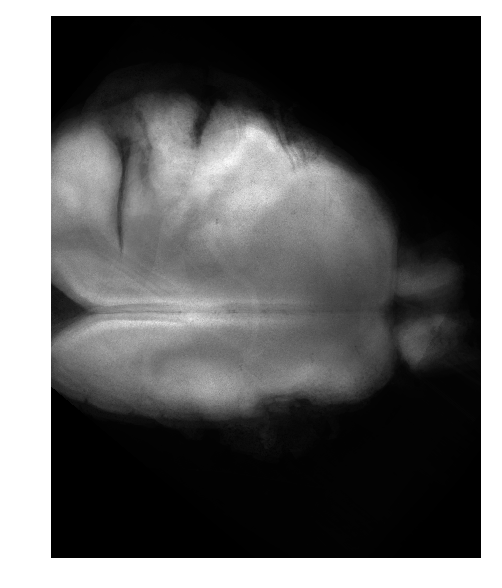

In [133]:
image(rotated.mean(axis=0))

### crop

In [134]:
mean = rotated.mean(axis=0)

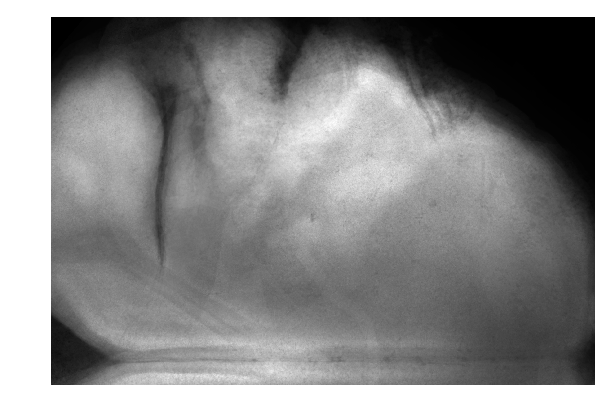

In [141]:
image(mean[650:-1900,:-700]);

In [142]:
cropped = rotated[1:-2,650:-1900,:-700]

In [143]:
imsave(directory + 'processed/cropped.tif', cropped, plugin='tifffile', photometric='minisblack')

### realign

In [146]:
realigned = align_stack(cropped, center=False)

In [147]:
imsave(directory + 'processed/realigned.tif', realigned, plugin='tifffile', photometric='minisblack')